<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/CSD2045/Generate_diagnostic_DPOAE_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook generates random, but realistic DPOAE data

This is intended for pedagogical purposes where new cases can be generated and audiological interpretation of the results can be practiced.

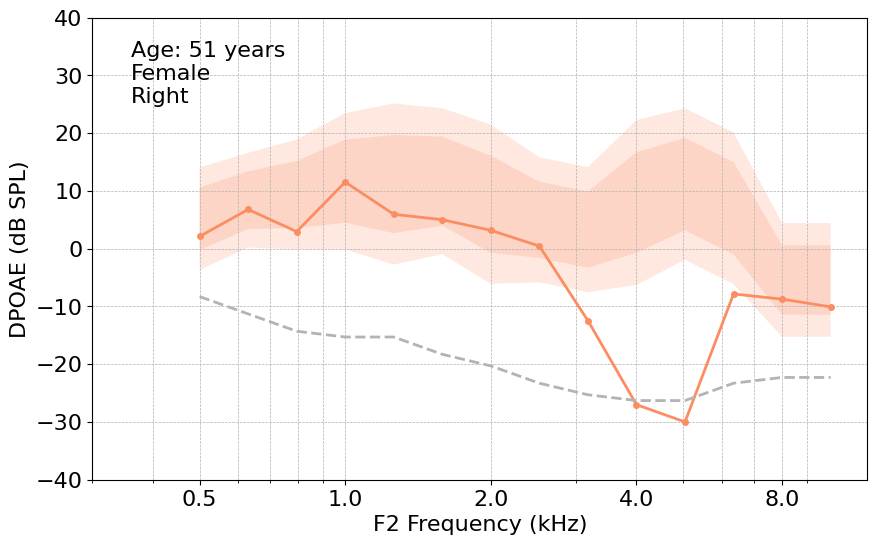

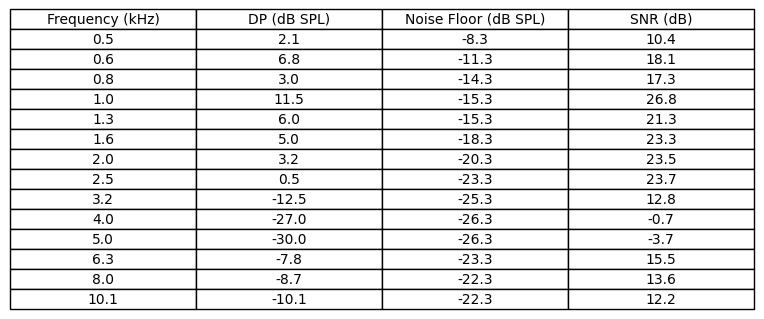

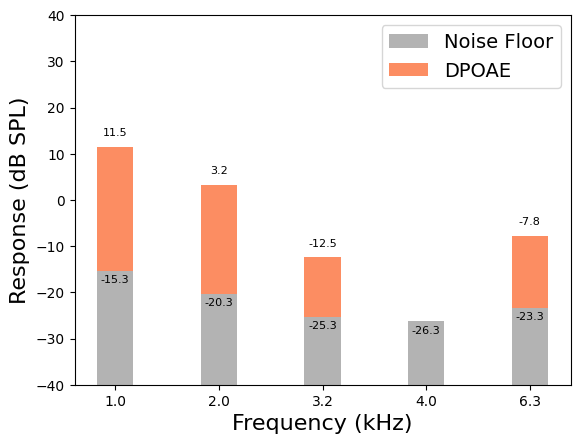

In [82]:
#@title This section generates the DPOAE case data and shows results!
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Frequencies
f = 0.5 * 2 ** np.arange(0, 13/3 + 1/3, 1/3)
fplot = 0.5 * 2 ** np.arange(0, 4 + 1)


m_male = np.array([2.5, 2.4, 6.2, 7, 10.9, 8.6, 4.4, 2.5, 2.7, 4, 5.1, -1.1, -5.4, -5.4])
m_female = np.array([5.2, 8.4, 9.4, 11.7, 11.2, 11.7, 7.7, 5, 3.3, 8, 11.2, 7, -5.4, -5.4])
sigma = np.array([5.4, 5, 5.8, 7.2, 8.5, 7.7, 8.4, 6.6, 6.6, 8.7, 8, 8, 6, 6])
dev_shift = np.array([0, 0, 0, 0, 1.5, 3, 4.5, 6, 6, 6, 6, 6, 4.5, 4.5])

m_noise = np.array([-9, -12, -15, -16, -16, -19, -21, -24, -26, -27, -27, -24, -23, -23])

n = m_noise

# Generate a new case
sex = np.random.choice([True, False])  # False is male, True is female

if sex:
  sex_string = f"Female"
else:
  sex_string = f"Male"


ear = np.random.choice([True, False])  # False is right, True is left
if ear:
  ear_string = f"Left"
else:
  ear_string = f"Right"


# Set whether norms are plotted or not
plotnorms = True  # np.random.choice([True, False])


# Generate a random age
# We'll consider a threshold age of 3 years.
# Ages below this will be in months, above in years

# First, decide whether the age is below 3 years (in months) or above (in years)
if np.random.rand() < 0.3:  # Make 30% of the data under age of 2 years
    # Age is less than 2 years, generate a random age in months (1 to 23 months)
    age = np.random.randint(1, 23) # Months
    age_string = f"Age: {age} months"
    age = age / 12.0  # Convert to years
else:
    # Age is 3 years or more, generate a random age in years (2 to 100 years)
    age = np.random.randint(3, 101)  # Years
    age_string = f"Age: {age} years"



# Create hearing loss profiles
loss = {
    'Normal': None,
    'Slope': None,
    'Flat': None,
    'Notch': None,
}

loss['Normal'] = np.zeros(14)

# Create profiles for sloping loss
first_half = np.zeros(7)
second_half = np.linspace(-5, -45, 7)
loss['Slope'] = np.concatenate((first_half, second_half))

# Create a notched loss profile
first_half = np.zeros(8)
middle = np.asarray([-15, -45, -45, -15])
high_freqs = np.zeros(2)
loss['Notch'] = np.concatenate((first_half, middle, high_freqs))

# Create a flat loss profile
loss['Flat'] = np.ones(14) * -40


# ----------------------------------------------
# Choose a random loss profile and generate data
# ----------------------------------------------
profile = np.random.choice(['Normal', 'Flat', 'Notch', 'Slope'])

while age > 60 and profile == 'Normal':  # Extra realism with age
  profile = np.random.choice(['Normal', 'Flat', 'Notch', 'Slope'])


while age < 7 and profile == 'Notch':   # NIHL unlikely at super young ages
  profile = np.random.choice(['Normal', 'Flat', 'Notch', 'Slope'])


shift = loss[profile]

# Also choose a scale factor for applying profile (kinda like degree of loss)
scale = max(np.random.rand(), 0.7)
shift = shift * scale

if sex:
  m = m_female
else:
  m = m_male

# Number of elements
n_elements = len(m)

# Create a covariance matrix that implies high correlation between elements
# For simplicity, set off-diagonal values to be some fraction of diagonal
correlation_factor = 0.95  # This should be less than 1
covariance_matrix = np.outer(sigma, sigma) * correlation_factor
# Set the diagonal to the variance of each element
np.fill_diagonal(covariance_matrix, sigma**2)

# Generate a random draw from a multivariate normal distribution
random_draw = np.random.multivariate_normal(m, covariance_matrix)
dp = random_draw + shift

# Generate noise floor
sigma_n = np.ones(14) * 6
covariance_matrix_n = np.outer(sigma_n, sigma_n) * correlation_factor
n = np.random.multivariate_normal(n, covariance_matrix_n)

while n[0] < -15:  # Avoid unrealistically low noise floor
  n = np.random.multivariate_normal(n, covariance_matrix_n)

# Find indices where dp is less than n
indices = dp < n

# For each index where dp is less than n, generate a random value in the specified range
for index in np.where(indices)[0]:
    lower_bound = n[index] - 5  # 5 below the value in n
    upper_bound = n[index] + 3  # 2 above the value in n (exclusive), hence +3
    dp[index] = np.random.randint(lower_bound, upper_bound)


# ----------------------------------------------
# Plot DPOAEs
# ----------------------------------------------

col = [102/255, 194/255, 165/255] if ear else [252/255, 141/255, 98/255]
marker = 'o'

plt.figure(figsize=(10, 6))

if plotnorms:
    m = m_female if sex else m_male
    if age <= 3:
      m = m + dev_shift

    if age > 3 and age <= 18:
      m = m + ((18.0 - age)/18.0) * dev_shift

    lo = m - sigma
    hi = m + sigma
    plt.fill_between(f, lo, hi, color=(*col, 0.2), edgecolor='none')

    lo = m - 1.64 * sigma
    hi = m + 1.64 * sigma
    plt.fill_between(f, lo, hi, color=(*col, 0.2), edgecolor='none')

plt.plot(f, dp, '-', marker=marker, color=col, linewidth=2, markersize=4)

# Noise plot
coln = [0.7, 0.7, 0.7]
plt.plot(f, n, '--', color=coln, linewidth=2)

# Axis and labels
plt.xscale('log')
tick_labels = [f"{x:.1f}" for x in fplot]  # Convert fplot values to string labels
plt.xticks(fplot, tick_labels)  # Set custom tick labels
plt.xlabel('F2 Frequency (kHz)', fontsize=16)
plt.ylabel('DPOAE (dB SPL)', fontsize=16)
plt.xlim([0.3, 12])
plt.ylim([-40, 40])
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.text(0.05, 0.95, age_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)
plt.text(0.05, 0.9, sex_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)
plt.text(0.05, 0.85, ear_string, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=16)

plt.show
plt.show()

# ----------------------------------------------
# Tabulate results too!
# ----------------------------------------------

# Calculate SNR
snr = dp - n

# Format the data with one decimal place
# Here we use numpy vectorize function to apply formatting to each element
format_func = np.vectorize(lambda x: f"{x:.1f}")
f_formatted = format_func(f)
dp_formatted = format_func(dp)
n_formatted = format_func(n)
snr_formatted = format_func(snr)

# Combine the formatted data for table display
table_data = np.column_stack((f_formatted, dp_formatted, n_formatted, snr_formatted))
column_labels = ["Frequency (kHz)", "DP (dB SPL)", "Noise Floor (dB SPL)", "SNR (dB)"]

# Create a figure and a plot
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')

# Adjust the table properties for aesthetics
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the scale for better spacing

plt.show()

# -----------------------
# Add code to show just screening frequencies as a bar plot
# -----------------------
# Specify the selected frequencies here
selected_indices =  [3, 6, 8, 9, 11] # Select 5 indices for screening

# Extract the corresponding dp and n values
selected_frequencies = [f[i] for i in selected_indices]
selected_dp = [dp[i] for i in selected_indices]
selected_n = [n[i] for i in selected_indices]

# Calculations for bar heights
base_to_noise_heights = [noise - (-40) for noise in selected_n]  # Heights from -40 to noise level
noise_to_dp_heights = [dp - noise for dp, noise in zip(selected_dp, selected_n)]  # Heights from noise level to DPOAE

# If DPOAE is below noise floor, then set height to 0
noise_to_dp_heights = [max(0, dp - noise) for dp, noise in zip(selected_dp, selected_n)]

# Create the bar plot
fig, ax = plt.subplots()
width = 0.35  # the width of the bars

# Equal spacing for x-axis ticks
x_ticks = np.arange(len(selected_frequencies))

# Plotting base to noise level
bars_n = ax.bar(x_ticks, base_to_noise_heights, width, bottom=-40, label='Noise Floor', color=coln)

# Plotting noise level to DPOAE
bars_dp = ax.bar(x_ticks, noise_to_dp_heights, width, bottom=selected_n, label='DPOAE', color=col)

plt.xlabel('Frequency (kHz)', fontsize=16)
plt.ylabel('Response (dB SPL)', fontsize=16)
ax.set_xticks(x_ticks)

# Formatting frequency labels to 1 decimal place
ax.set_xticklabels([f"{freq:.1f}" for freq in selected_frequencies])
ax.legend(fontsize=14)
plt.ylim((-40, 40))

# Loop through the bars and add text annotations
for i in range(len(x_ticks)):
    # Annotate noise level
    noise_value = selected_n[i]
    ax.text(x_ticks[i], noise_value - 3, f"{noise_value:.1f}", ha='center', va='bottom', color='black', fontsize=8)

    # Annotate DPOAE level
    dp_value = selected_dp[i]
    if dp_value <= noise_value:
      continue
    ax.text(x_ticks[i], dp_value + 2, f"{dp_value:.1f}", ha='center', va='bottom', color='black', fontsize=8)
plt.show()
